In [1]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 3.6 MB/s eta 0:00:00


# Ensembles

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carregando o conjunto de dados e separando em treino e teste

In [3]:
import pandas as pd
import os

In [4]:
WORK_DIR = '/content/drive/My Drive/datasets'
DATA_DIR = os.path.join(WORK_DIR, 'olist')
df_abt = pd.read_csv(os.path.join(DATA_DIR, 'propensao_revenda_abt.csv'))
df_abt.head()

,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,nao_revendeu_next_6m
0,2018-01-01,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,74,1
1,2018-01-01,001cca7ae9ae17fb1caed9dfb1094831,ES,171,207,9,21275.23,2,0
2,2018-01-01,002100f778ceb8431b7a1020ff7ab48f,SP,38,42,15,781.80,2,0
3,2018-01-01,003554e2dce176b5555353e4f3555ac8,GO,1,1,1,120.00,16,1
4,2018-01-01,004c9cd9d87a3c30c522c48c4fc07416,SP,130,141,75,16228.88,8,0


In [5]:
df_train = df_abt.query('data_ref_safra < "2018-03-01"')
df_oot = df_abt.query('data_ref_safra == "2018-03-01"')

key_vars = ['data_ref_safra', 'seller_id']
num_vars = ['tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia']
cat_vars = ['uf']
target = 'nao_revendeu_next_6m'
features = cat_vars + num_vars

# Dados de treinamento
X_train = df_train[features]
y_train = df_train[target]

# Dados de avaliação (out of time)
X_oot = df_oot[features]
y_oot = df_oot[target]

## Definindo quais previsores (algoritmos) serão utilizados

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

logit = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
svc = SVC(random_state=42)

voto_ensembles = VotingClassifier(
    estimators = [('logit', logit),('dt', dt),('svc', svc)],
    voting='hard'
)

## Criando um pipeline para transformar os dados

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper

In [8]:
pipeline_vote = Pipeline(steps=[
    ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
    ('numeric_scaler', SklearnTransformerWrapper(variables=num_vars, transformer=StandardScaler())),
    ('categoric_imputer', CategoricalImputer(variables=cat_vars, return_object=True)),
    ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
    ('vote_ensembles', voto_ensembles)
])

In [9]:
pipeline_vote.fit(X_train, y_train)

Pipeline(steps=[('numeric_imputer',
                 ArbitraryNumberImputer(arbitrary_number=-999,
                                        variables=['tot_orders_12m',
                                                   'tot_items_12m',
                                                   'tot_items_dist_12m',
                                                   'receita_12m',
                                                   'recencia'])),
                ('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['tot_orders_12m',
                                                      'tot_items_12m',
                                                      'tot_items_dist_12m',
                                                      'receita_12m',
                                                      'recencia'])),
                ('categoric_imputer',
                 CategoricalImputer(return_object=True, variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('vote_ensembles',
                 VotingClassifier(estimators=[('logit',
                                               LogisticRegression(random_state=42)),
                                              ('dt',
                                               DecisionTreeClassifier(random_state=42)),
                                              ('svc', SVC(random_state=42))]))])

In [10]:
print(pipeline_vote.get_params())

{'memory': None, 'steps': [('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=-999,
                       variables=['tot_orders_12m', 'tot_items_12m',
                                  'tot_items_dist_12m', 'receita_12m',
                                  'recencia'])), ('numeric_scaler', SklearnTransformerWrapper(transformer=StandardScaler(),
                          variables=['tot_orders_12m', 'tot_items_12m',
                                     'tot_items_dist_12m', 'receita_12m',
                                     'recencia'])), ('categoric_imputer', CategoricalImputer(return_object=True, variables=['uf'])), ('one_hot_encoder', OneHotEncoder(variables=['uf'])), ('vote_ensembles', VotingClassifier(estimators=[('logit', LogisticRegression(random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))]))], 'verbose': False, 'numeric_imputer': ArbitraryNumberImputer(arbitrary_nu

## Realizando a acurácia de cada classificador

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
for clf in (logit, dt, svc, voto_ensembles):
  pipe = Pipeline(steps=[
            ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
            ('numeric_scaler', SklearnTransformerWrapper(variables=num_vars, transformer=StandardScaler())),
            ('categoric_imputer', CategoricalImputer(variables=cat_vars, return_object=True)),
            ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
            ('clf', clf)
  ])

  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_oot)
  print(pipe[-1].__class__.__name__, accuracy_score(y_oot, y_pred))

LogisticRegression 0.8255069370330843
DecisionTreeClassifier 0.7913553895410885
SVC 0.8329775880469584
VotingClassifier 0.8303094983991463


## Bagging e Pasting

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

O BaggingClassifier executa automaticamente um soft voting em vez de um hard voting, se o classificador puder estimar as probabilidades da classe.

No caso o método `predict_proba()`.

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,
    random_state=42
)

Os parâmetros:

- `bootstrap=True` significa que que será utilizada a técnica bagging. Para utilizar a técnica pasting, utilize boostrap=False.
- `n_jobs=-1` significa que todos os núcleos da CPU serão utilizados para processar em paralelo.
- `oob_score=True` - avaliação Out-of-Bag.

Por padrão, um BaggingClassifier amostra `m` instâncias de treinamento com substituição (boostrap=True), sendo `m` o tamanho do conjunto. Isto significa que somente 63% das instâncias de treinamento são amostradas na média para cada previsor. Os 37% restante são chamadas de instâncias out-of-bag.

Como um previsor nunca vê as instâncias `oob` durante o treinamento, ele pode ser avaliado nessas instâncias sem a necessidade de um conjunto de validação separado ou de validação cruzada.


In [15]:
pipe = Pipeline(steps=[
          ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
          ('numeric_scaler', SklearnTransformerWrapper(variables=num_vars, transformer=StandardScaler())),
          ('categoric_imputer', CategoricalImputer(variables=cat_vars, return_object=True)),
          ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
          ('bag_clf', bag_clf)
])

In [16]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('numeric_imputer',
                 ArbitraryNumberImputer(arbitrary_number=-999,
                                        variables=['tot_orders_12m',
                                                   'tot_items_12m',
                                                   'tot_items_dist_12m',
                                                   'receita_12m',
                                                   'recencia'])),
                ('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['tot_orders_12m',
                                                      'tot_items_12m',
                                                      'tot_items_dist_12m',
                                                      'receita_12m',
                                                      'recencia'])),
                ('categoric_imputer',
                 CategoricalImputer(return_object=True, variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('bag_clf',
                 BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                   max_samples=100, n_estimators=500, n_jobs=-1,
                                   oob_score=True, random_state=42))])

In [17]:
y_pred = pipe.predict(X_oot)
print(pipe[-1].__class__.__name__, accuracy_score(y_oot, y_pred))

BaggingClassifier 0.8351120597652081


In [18]:
# Para visualizar o score na base de Out-of-Bag.
print(pipe[-1].__class__.__name__, 'Out-of-Bag', pipe[-1].oob_score_)

BaggingClassifier Out-of-Bag 0.8309012875536481


# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps=[
    ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
    ('categoric_imputer', CategoricalImputer(variables=cat_vars, return_object=True)),
    ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
    ('Random Forest', RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True, random_state=42))
])

In [20]:
rf.fit(X_train, y_train)

Pipeline(steps=[('numeric_imputer',
                 ArbitraryNumberImputer(arbitrary_number=-999,
                                        variables=['tot_orders_12m',
                                                   'tot_items_12m',
                                                   'tot_items_dist_12m',
                                                   'receita_12m',
                                                   'recencia'])),
                ('categoric_imputer',
                 CategoricalImputer(return_object=True, variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('Random Forest',
                 RandomForestClassifier(n_estimators=500, n_jobs=-1,
                                        oob_score=True, random_state=42))])

In [21]:
y_pred = rf.predict(X_oot)
print(rf[-1].__class__.__name__, accuracy_score(y_oot, y_pred))

RandomForestClassifier 0.8703308431163287


In [22]:
print(rf[-1].__class__.__name__, 'Out-of-Bag', rf[-1].oob_score_)

RandomForestClassifier Out-of-Bag 0.8457796852646638


## Recuperando as 10 features mais importantes

In [23]:
# Recuperar os nomes das variáveis após a aplicação das transformações
rf[-2].transform(X_train).columns

Index(['tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m',
       'recencia', 'uf_SP', 'uf_ES', 'uf_GO', 'uf_PR', 'uf_MG', 'uf_RN',
       'uf_SC', 'uf_RJ', 'uf_RS', 'uf_PB', 'uf_DF', 'uf_PE', 'uf_MT', 'uf_AM',
       'uf_RO', 'uf_CE', 'uf_BA', 'uf_SE', 'uf_MS', 'uf_PA', 'uf_MA', 'uf_PI'],
      dtype='object')

In [24]:
import pandas as pd

importancia_features = pd.Series(
    data = rf[-1].feature_importances_,
    index = rf[-2].transform(X_train).columns
)

importancia_features.sort_values(ascending=False,inplace=True)
importancia_features[:10]

recencia              0.473708
receita_12m           0.196334
tot_orders_12m        0.101043
tot_items_12m         0.099548
tot_items_dist_12m    0.071831
uf_SP                 0.010532
uf_PR                 0.007998
uf_MG                 0.007097
uf_SC                 0.006949
uf_RJ                 0.005923
dtype: float64

<Axes: >

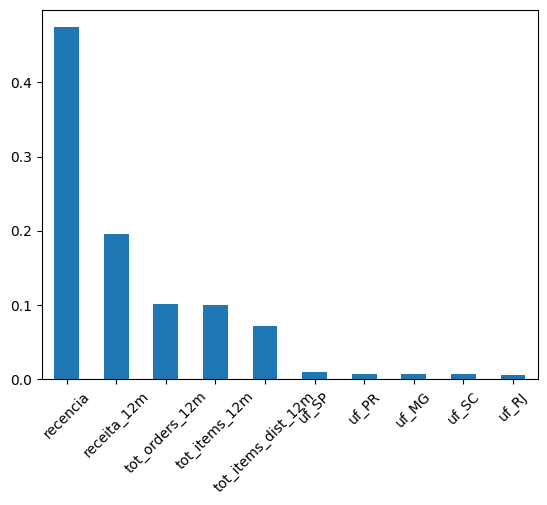

In [25]:
importancia_features[:10].plot(kind='bar', rot=45)